In [1]:
import sys

sys.path.append("..")

from core.DataLoader import DataPreprocessor, get_load_config_from_yaml
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml
import core.keras_models as Models
import core
import os


if False:
    PLOTS_DIR = "plots/ToponiumInfusedTransformer/"
    MODEL_DIR = "models/mixed_model"
elif True:
    PLOTS_DIR = "plots/RegressionTransformer_pil/"
else:
    PLOTS_DIR = "plots/RegressionTransformer_/"
    MODEL_DIR = "../models/regression_transformer_old/"


CONFIG_PATH = "../config/workspace_config.yaml"

# Create directories
os.makedirs(PLOTS_DIR, exist_ok=True)

# Set plotting style
plt.rcParams.update({"font.size": 18})

from core.utils import lorentz_vector_from_PtEtaPhiE_array
from core.evaluation import c_hel, c_han

# Load data
load_config = get_load_config_from_yaml(CONFIG_PATH)
DataProcessor = DataPreprocessor(load_config)
data_config = DataProcessor.load_from_npz(
    load_config.data_path["nominal"], event_numbers="odd", max_events=2_000_000
)
DataProcessor.add_custom_feature(
    (
        lambda X, data_config: c_hel(
            lorentz_vector_from_PtEtaPhiE_array(X["top_truth"][:, 0, :4]),
            lorentz_vector_from_PtEtaPhiE_array(X["top_truth"][:, 1, :4]),
            lorentz_vector_from_PtEtaPhiE_array(X["lepton_truth"][:, 0, :4]),
            lorentz_vector_from_PtEtaPhiE_array(X["lepton_truth"][:, 1, :4]),
        )
    ),
    "c_hel",
)
DataProcessor.add_custom_feature(
    (
        lambda X, data_config: c_han(
            lorentz_vector_from_PtEtaPhiE_array(X["top_truth"][:, 0, :4]),
            lorentz_vector_from_PtEtaPhiE_array(X["top_truth"][:, 1, :4]),
            lorentz_vector_from_PtEtaPhiE_array(X["lepton_truth"][:, 0, :4]),
            lorentz_vector_from_PtEtaPhiE_array(X["lepton_truth"][:, 1, :4]),
        )
    ),
    "c_han",
)

X, y = DataProcessor.get_data()
del DataProcessor

2026-02-05 11:13:51.558165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770286431.586170  659321 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770286431.595316  659321 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770286431.616675  659321 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770286431.616707  659321 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770286431.616710  659321 computation_placer.cc:177] computation placer alr

In [2]:
import core.reconstruction.BaselineMethods as BaselineMethods
import core.evaluation.reconstruction_evaluator as Evaluation
from core.reconstruction import (
    GroundTruthReconstructor,
    PerfectAssignmentReconstructor,
    CompositeNeutrinoComponentReconstructor,
)

reload(Evaluation)
reload(BaselineMethods)
ground_truth_assigner = GroundTruthReconstructor(data_config, use_nu_flows=True)
transformer = PerfectAssignmentReconstructor(
    data_config, neutrino_reco_name=r"Transformer $\nu$"
)
MODEL_DIR = "../models/regression_transformer/"
transformer.load_model(f"{MODEL_DIR}/odd_model.keras")
transformer_cartesian = PerfectAssignmentReconstructor(
    data_config, neutrino_reco_name=r"Transformer (Cartesian) $\nu$"
)
MODEL_DIR = "../models/regression_transformer_cartesian/"
transformer_cartesian.load_model(f"{MODEL_DIR}/odd_model.keras")



prediction_manager = Evaluation.PredictionManager(
    [ground_truth_assigner,transformer,transformer_cartesian], X, y#, load_directory=PREDICTIONS_DIR
)

evaluator = Evaluation.ReconstructionEvaluator(prediction_manager)

I0000 00:00:1770286545.490691  659321 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11833 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:65:00.0, compute capability: 6.0


Model loaded from ../models/regression_transformer//odd_model.keras
Training history loaded from ../models/regression_transformer//odd_model_history.npz
Model loaded from ../models/regression_transformer_cartesian//odd_model.keras
Training history loaded from ../models/regression_transformer_cartesian//odd_model_history.npz


I0000 00:00:1770286550.871591  661455 service.cc:152] XLA service 0x7f1284001d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770286550.871620  661455 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2026-02-05 11:15:50.970455: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1770286551.554325  661455 cuda_dnn.cc:529] Loaded cuDNN version 91500
I0000 00:00:1770286553.517964  661455 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [3]:
PLOTS_DIR = "plots/RegressionTransformer_cartesian/"

Using cached reconstructed variable 'W_mass' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'W_mass' for reconstructor True Assignment + Transformer $\nu$.
Using cached reconstructed variable 'W_mass' for reconstructor True Assignment + Transformer (Cartesian) $\nu$.


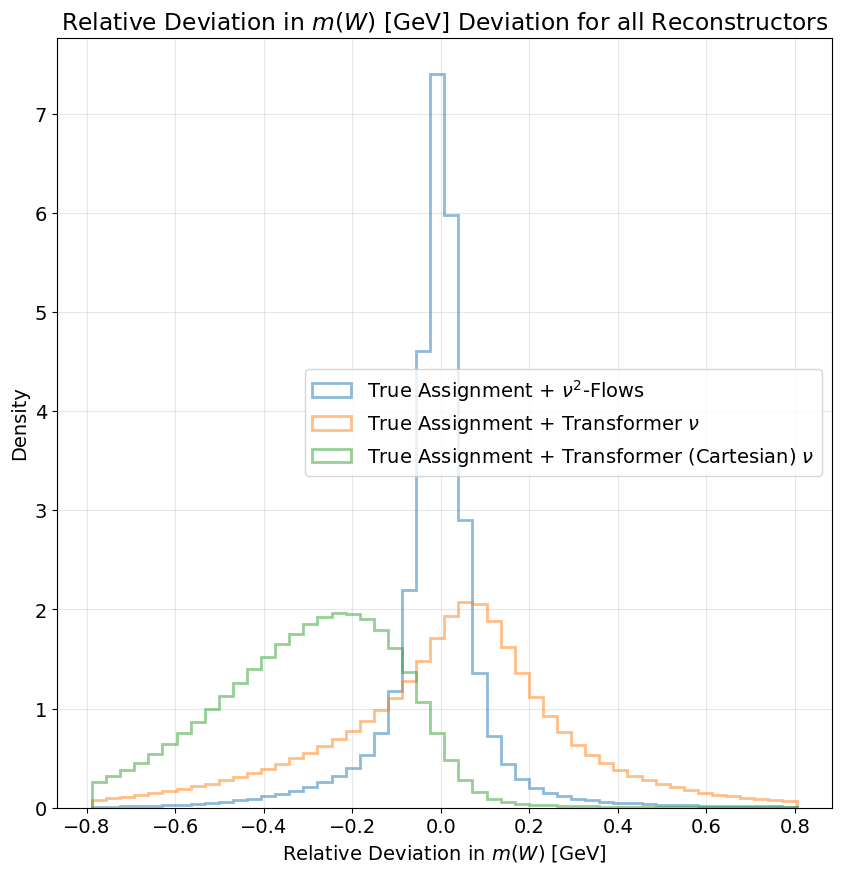

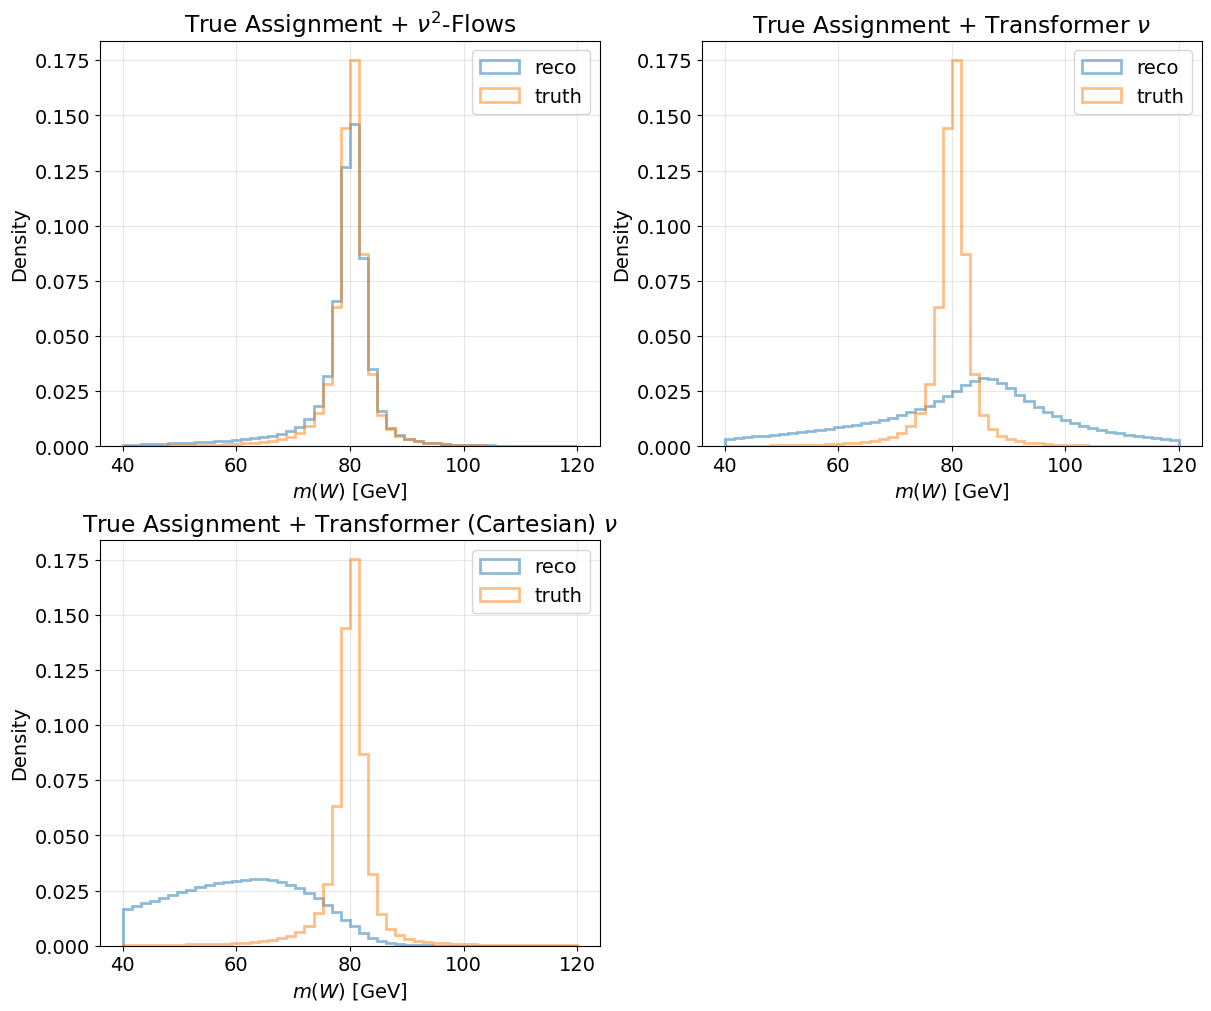

In [4]:
plt.rcParams.update({"font.size": 14})

fig, ax = evaluator.plot_variable_deviation("W_mass")
fig.savefig(os.path.join(PLOTS_DIR, "W_mass_deviation.pdf"), bbox_inches="tight")
fig, ax = evaluator.plot_variable_distribution("W_mass", xlims=(40, 120))
fig.savefig(os.path.join(PLOTS_DIR, "W_mass_distribution.pdf"), bbox_inches="tight")

Using cached reconstructed variable 'W_energy' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'W_energy' for reconstructor True Assignment + Transformer $\nu$.
Using cached reconstructed variable 'W_energy' for reconstructor True Assignment + Transformer (Cartesian) $\nu$.


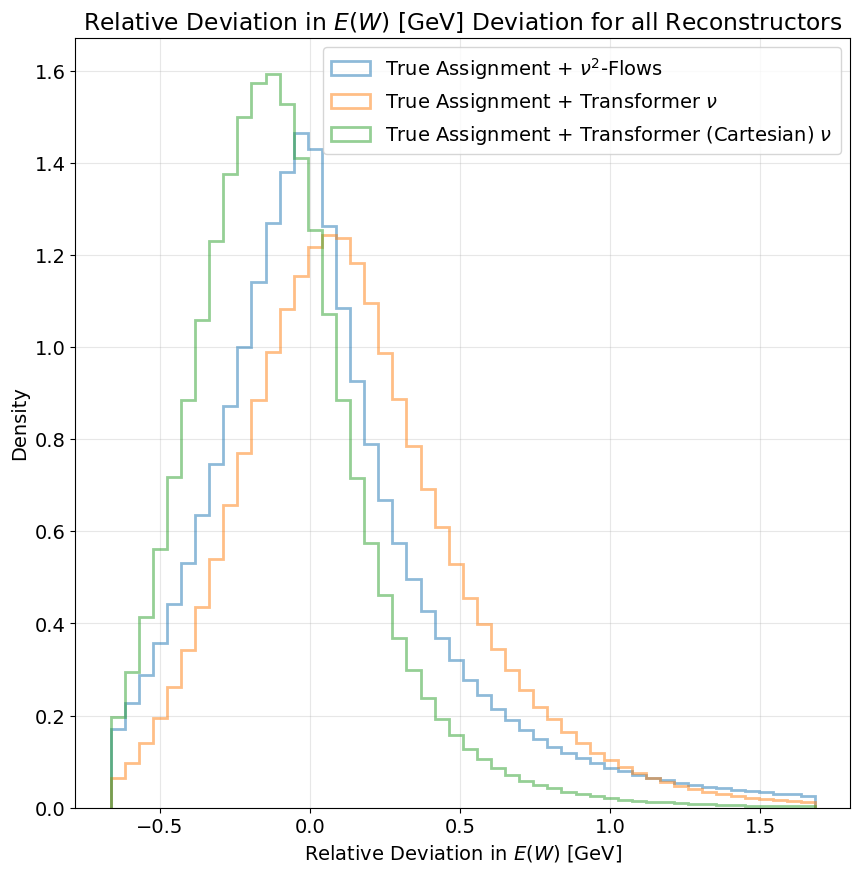

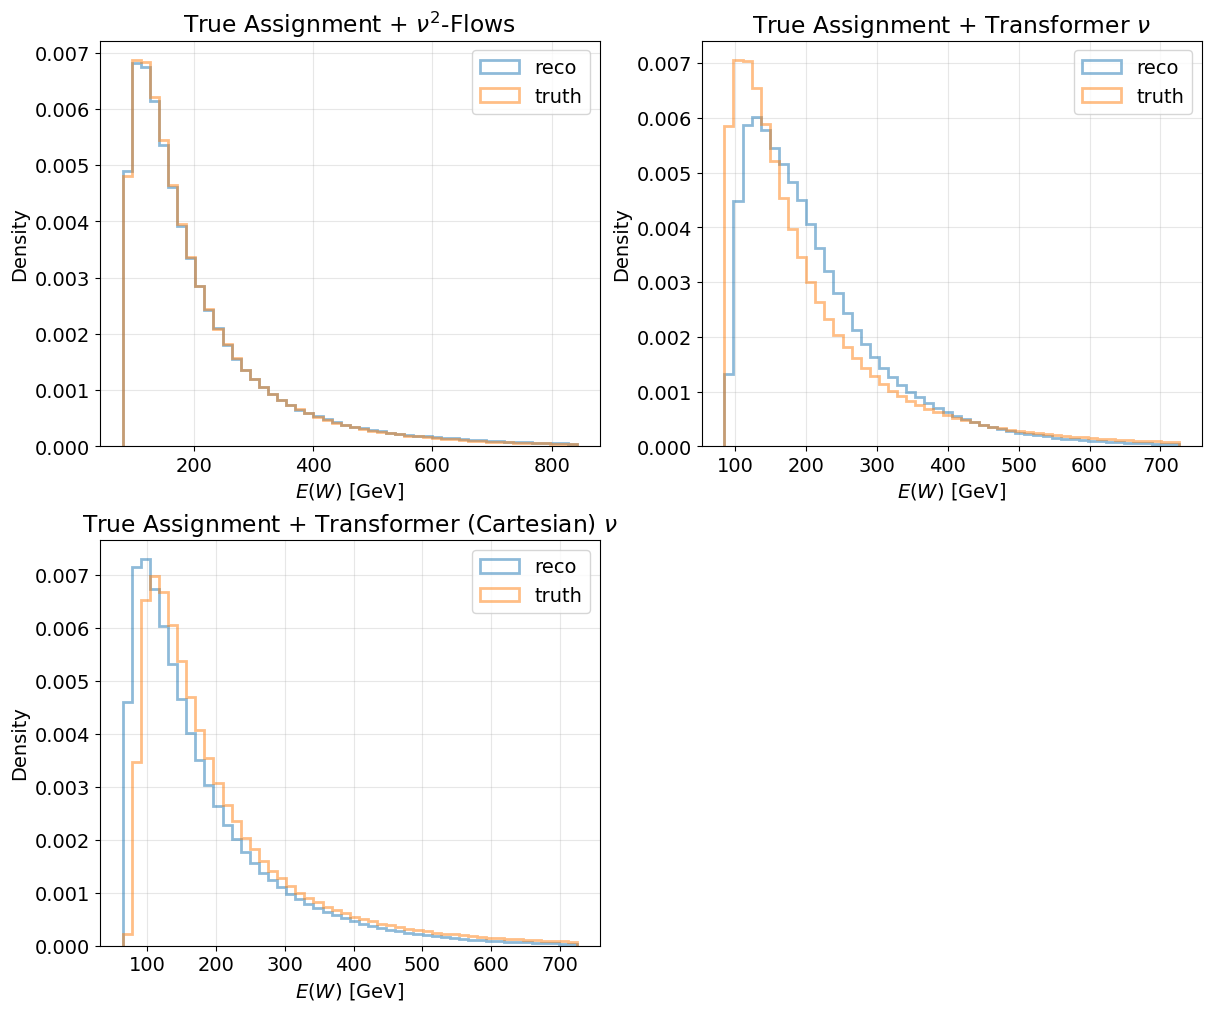

In [5]:
fig, ax = evaluator.plot_variable_deviation("W_energy")
fig.savefig(os.path.join(PLOTS_DIR, "W_energy_deviation.pdf"), bbox_inches="tight")
fig, ax = evaluator.plot_variable_distribution("W_energy")
fig.savefig(os.path.join(PLOTS_DIR, "W_energy_distribution.pdf"), bbox_inches="tight")


Computing binned Mean $c_{\text{hel}}$ Deviation for truth_ttbar_mass...

Computing binned Mean $c_{\text{han}}$ Deviation for truth_ttbar_mass...

Computing binned $c_{\text{hel}}$ Resolution for truth_ttbar_mass...
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + Transformer $\nu$.
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + Transformer (Cartesian) $\nu$.

Computing binned $c_{\text{han}}$ Resolution for truth_ttbar_mass...
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + Transformer $\nu$.
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + Transformer (Cartesian) $\nu$.


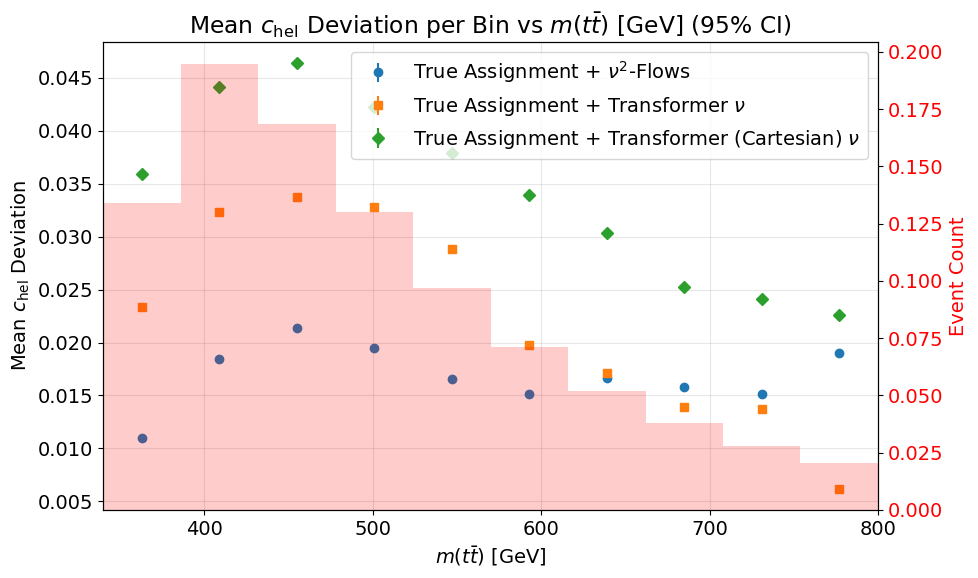

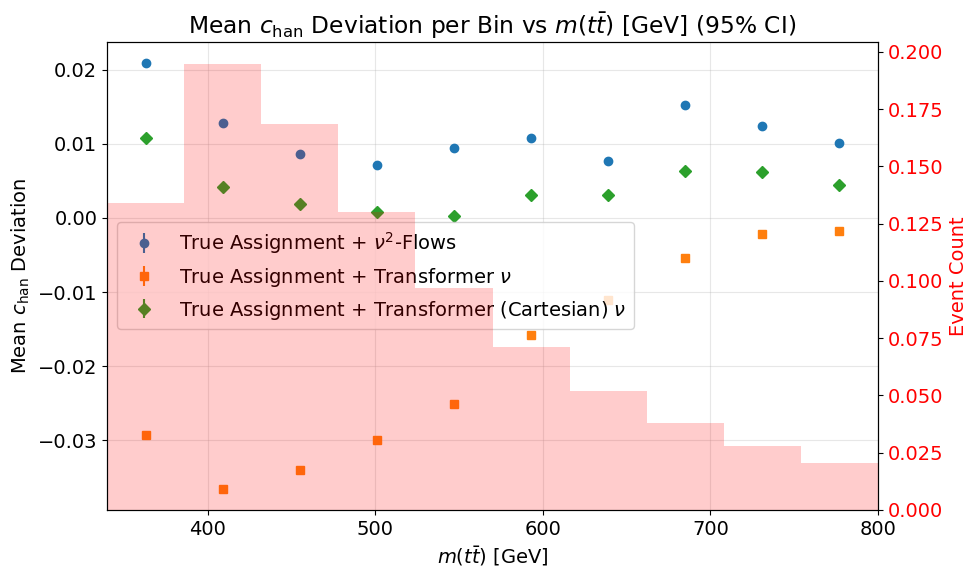

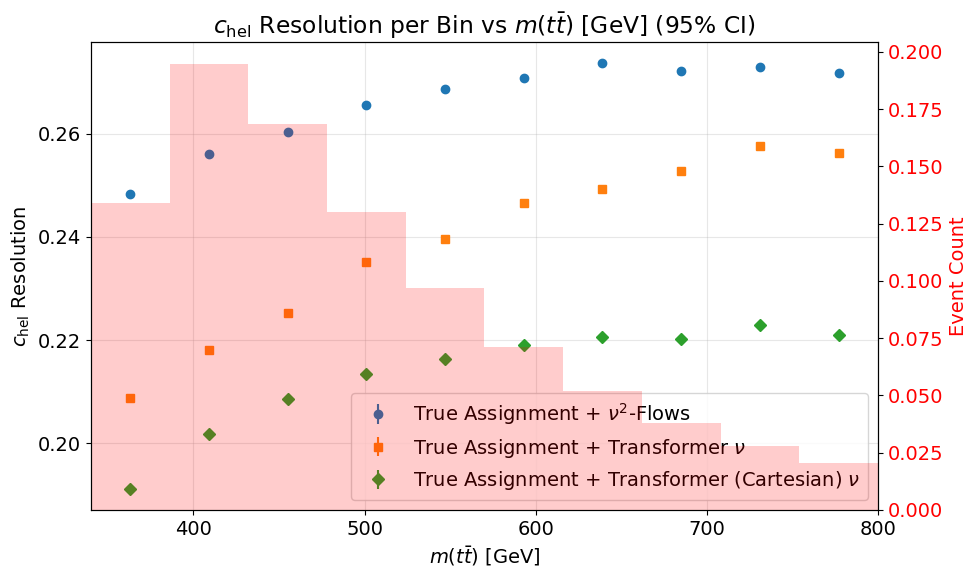

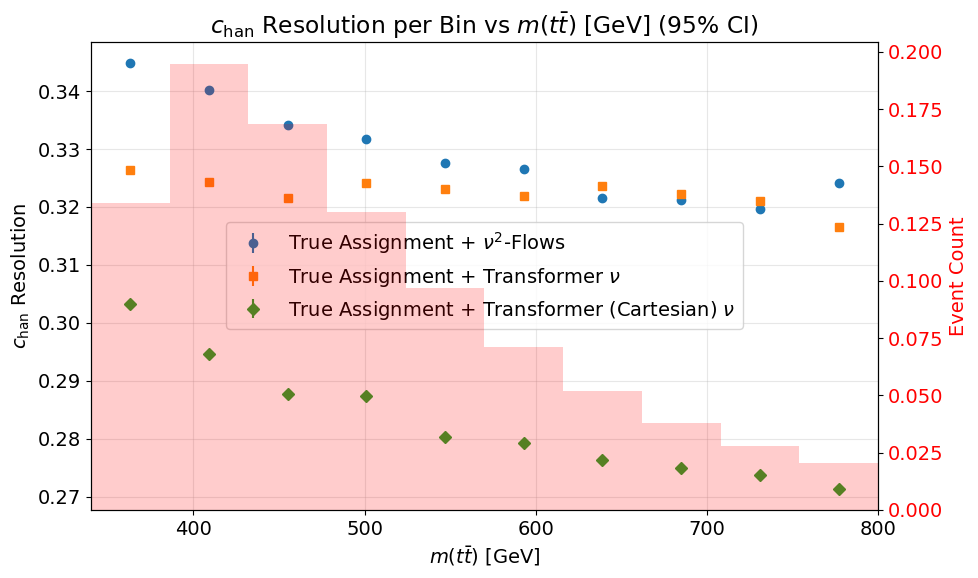

In [6]:
fig, ax = evaluator.plot_binned_variable(
    "c_hel",
    "deviation",
    "non_training",
    "truth_ttbar_mass",
    xlims=(340e3, 800e3),
    bins=10,
    fancy_feature_label=r"$m(t\bar{t})$ [GeV]",
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(f"{PLOTS_DIR}/c_hel_deviation_vs_ttbar_mass.pdf", bbox_inches="tight")
fig, ax = evaluator.plot_binned_variable(
    "c_han",
    "deviation",
    "non_training",
    "truth_ttbar_mass",
    xlims=(340e3, 800e3),
    bins=10,
    fancy_feature_label=r"$m(t\bar{t})$ [GeV]",
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(f"{PLOTS_DIR}/c_han_deviation_vs_ttbar_mass.pdf", bbox_inches="tight")
fig, ax = evaluator.plot_binned_variable(
    "c_hel",
    "resolution",
    "non_training",
    "truth_ttbar_mass",
    xlims=(340e3, 800e3),
    bins=10,
    fancy_feature_label=r"$m(t\bar{t})$ [GeV]",
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(f"{PLOTS_DIR}/c_hel_resolution_vs_ttbar_mass.pdf", bbox_inches="tight")
fig, ax = evaluator.plot_binned_variable(
    "c_han",
    "resolution",
    "non_training",
    "truth_ttbar_mass",
    xlims=(340e3, 800e3),
    bins=10,
    fancy_feature_label=r"$m(t\bar{t})$ [GeV]",
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(f"{PLOTS_DIR}/c_han_resolution_vs_ttbar_mass.pdf", bbox_inches="tight")


Computing binned Mean $c_{\text{hel}}$ Deviation for c_hel...
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + Transformer $\nu$.
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + Transformer (Cartesian) $\nu$.

Computing binned Mean $c_{\text{han}}$ Deviation for c_han...
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + Transformer $\nu$.
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + Transformer (Cartesian) $\nu$.


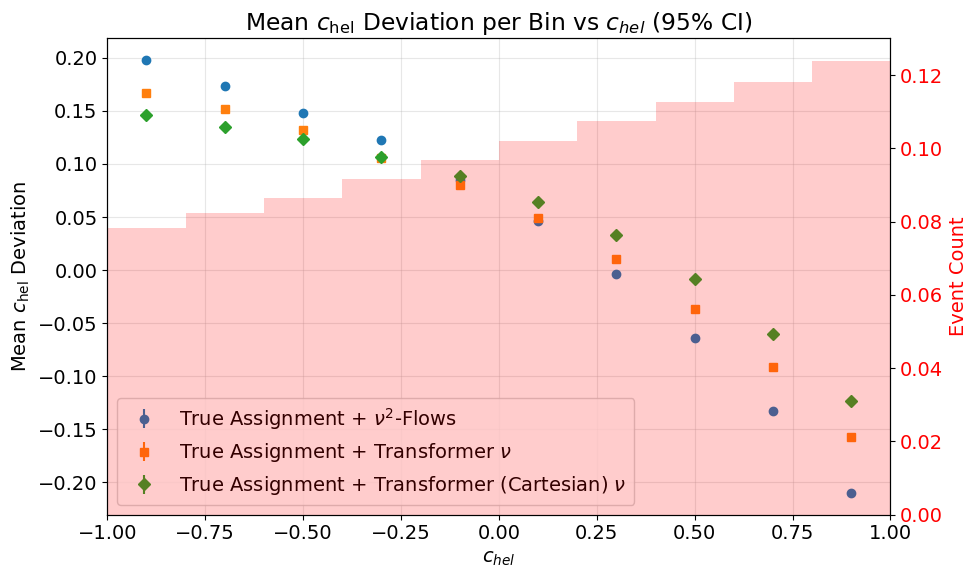

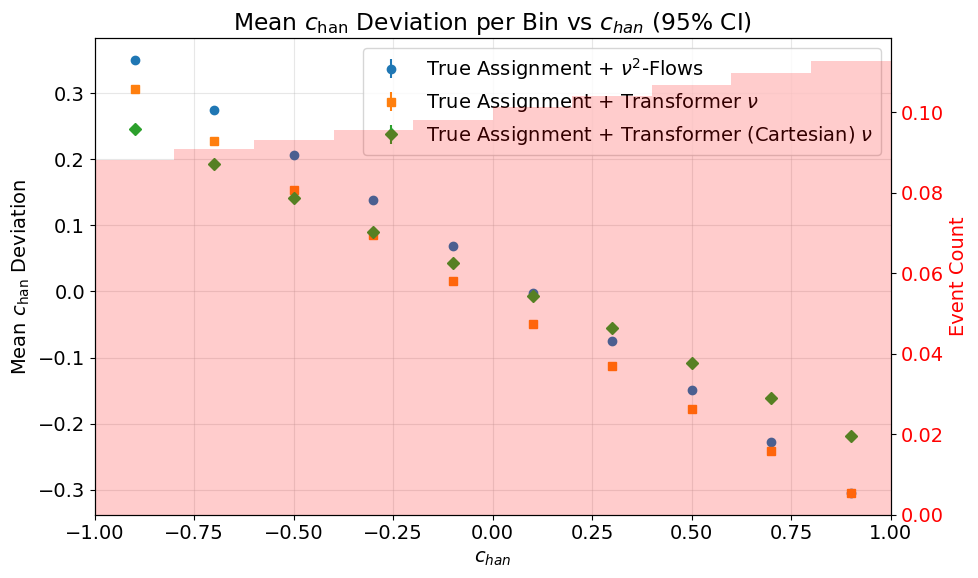

In [7]:
fig, ax = evaluator.plot_binned_variable(
    "c_hel",
    "deviation",
    "custom",
    "c_hel",
    xlims=(-1, 1),
    bins=10,
    fancy_feature_label=r"$c_{hel}$",
)
fig.savefig(f"{PLOTS_DIR}/c_hel_deviation_vs_c_hel.pdf", bbox_inches="tight")
fig, ax = evaluator.plot_binned_variable(
    "c_han",
    "deviation",
    "custom",
    "c_han",
    xlims=(-1, 1),
    bins=10,
    fancy_feature_label=r"$c_{han}$",
)
ticks = ax.get_xticks()
fig.savefig(f"{PLOTS_DIR}/c_han_deviation_vs_c_han.pdf", bbox_inches="tight")


Computing binned $c_{\text{hel}}$ Resolution for c_hel...
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + Transformer $\nu$.
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + Transformer (Cartesian) $\nu$.

Computing binned $c_{\text{han}}$ Resolution for c_han...
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + Transformer $\nu$.
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + Transformer (Cartesian) $\nu$.


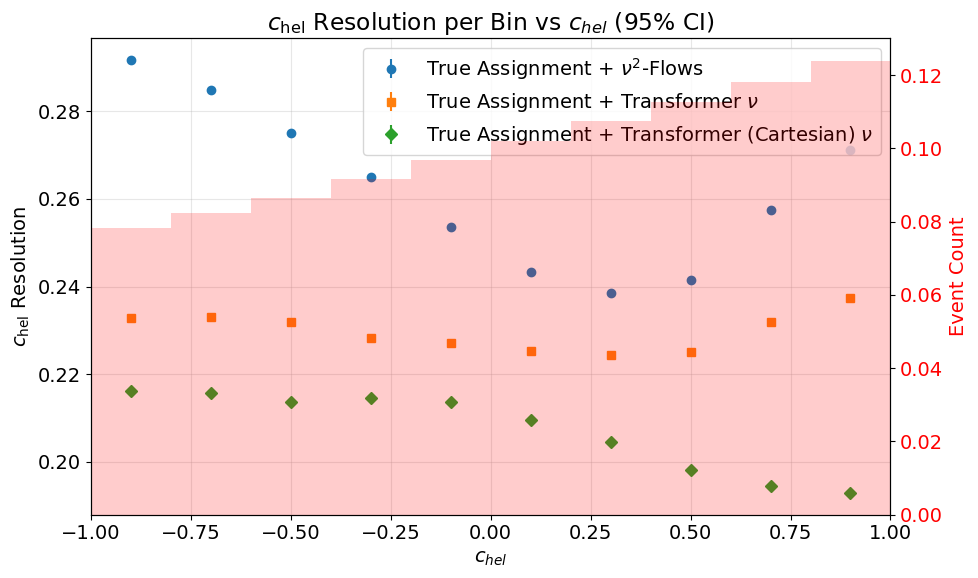

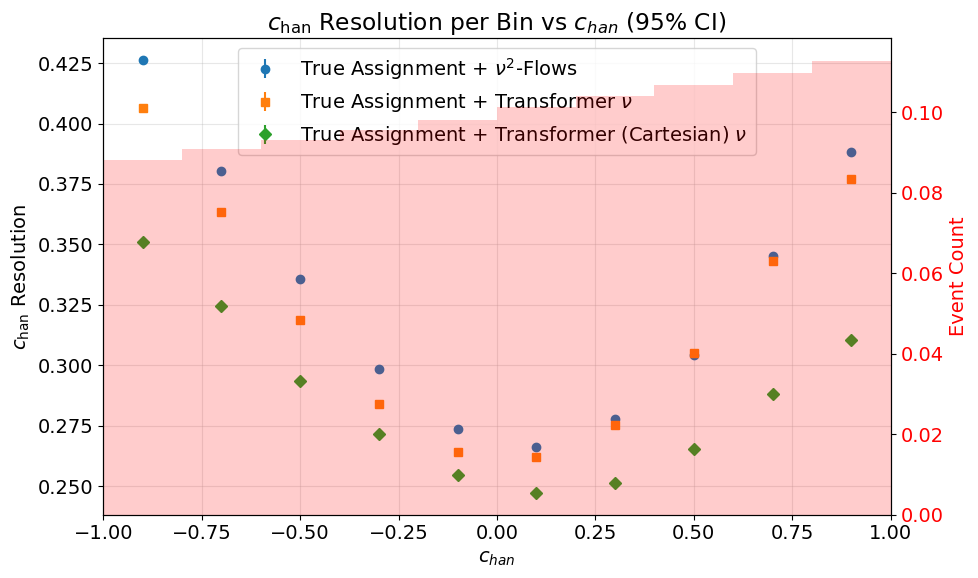

In [8]:
fig, ax = evaluator.plot_binned_variable(
    "c_hel",
    "resolution",
    "custom",
    "c_hel",
    xlims=(-1, 1),
    bins=10,
    fancy_feature_label=r"$c_{hel}$",
)
fig.savefig(f"{PLOTS_DIR}/c_hel_resolution_vs_c_hel.pdf", bbox_inches="tight")
fig, ax = evaluator.plot_binned_variable(
    "c_han",
    "resolution",
    "custom",
    "c_han",
    xlims=(-1, 1),
    bins=10,
    fancy_feature_label=r"$c_{han}$",
)
ticks = ax.get_xticks()
fig.savefig(f"{PLOTS_DIR}/c_han_resolution_vs_c_han.pdf", bbox_inches="tight")

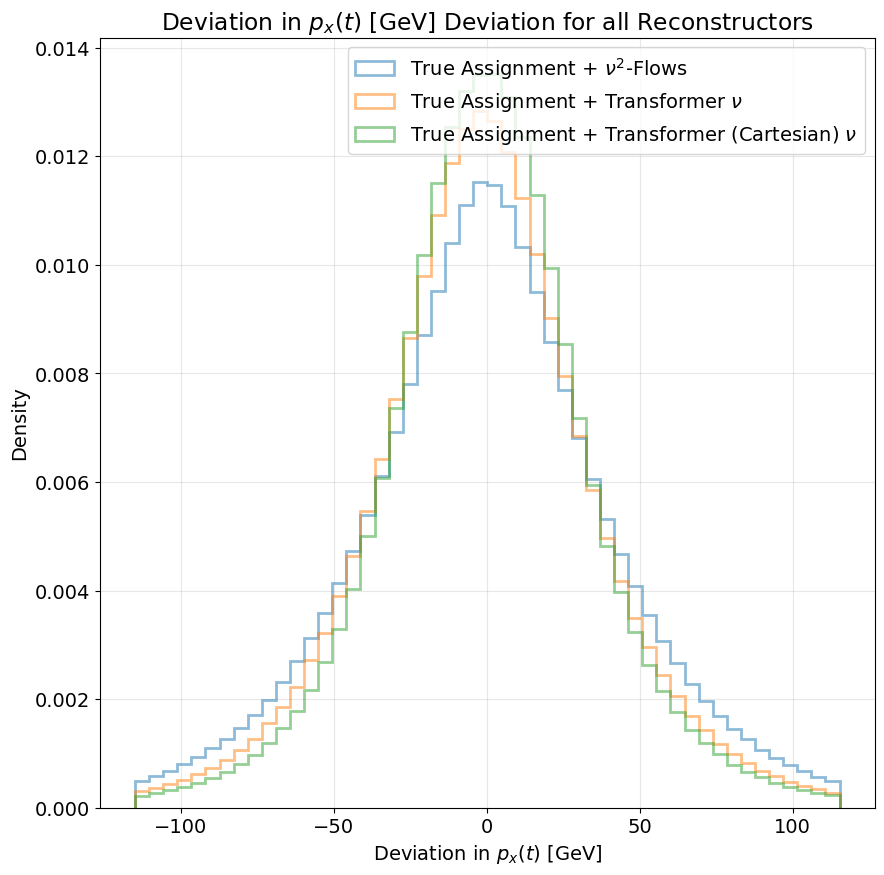

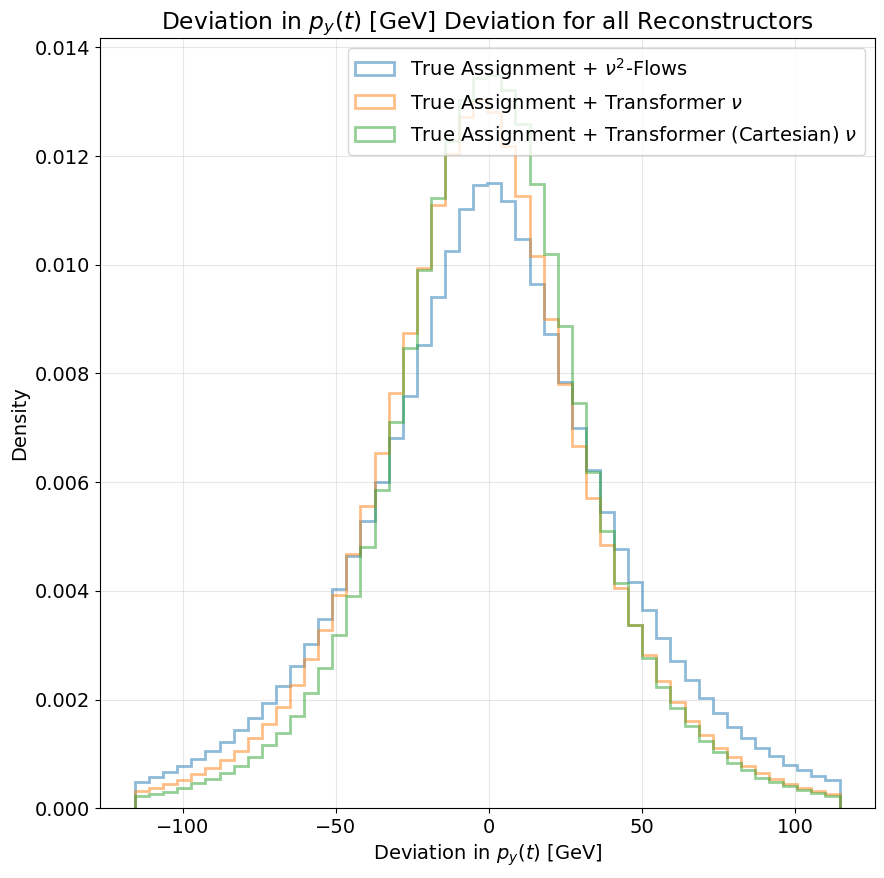

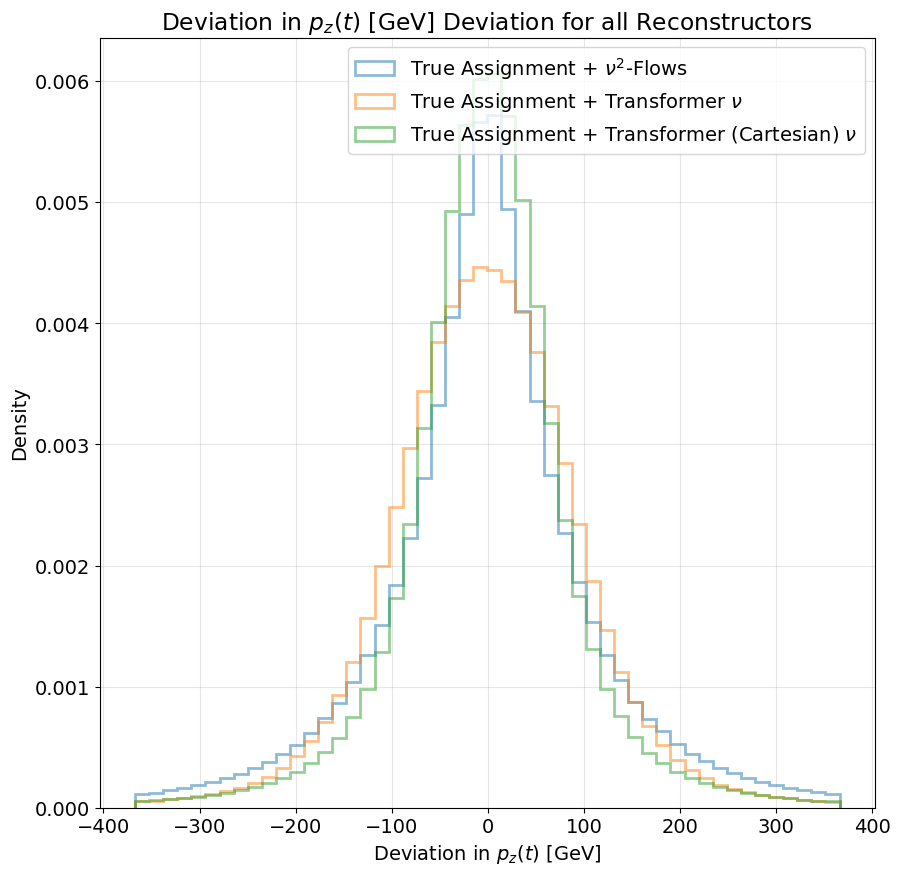

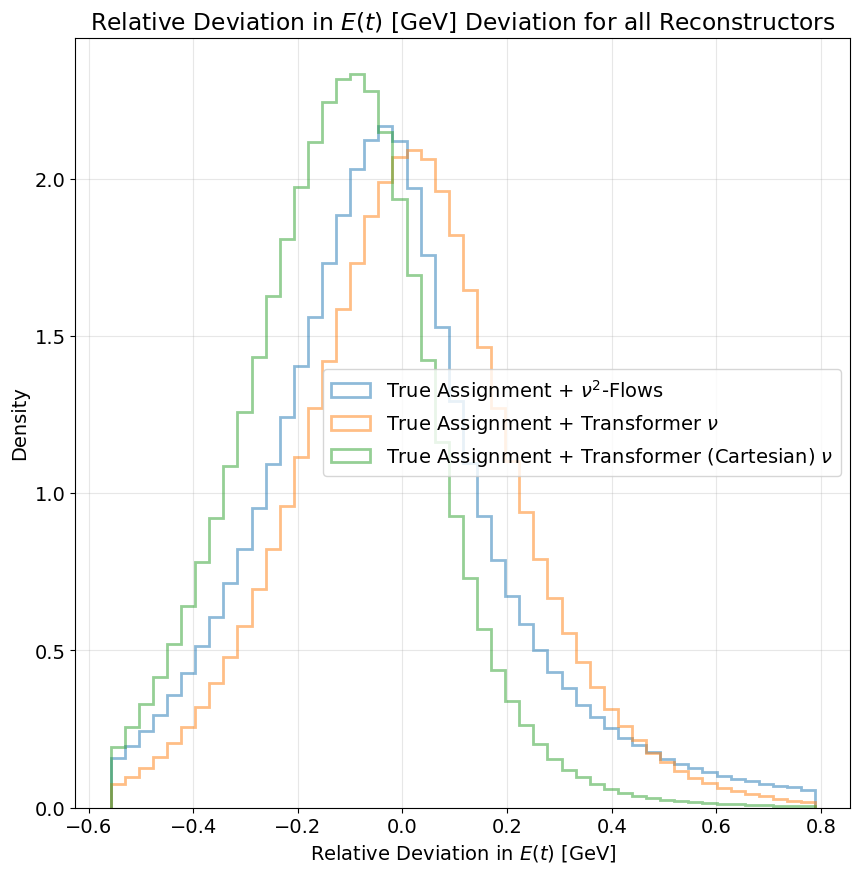

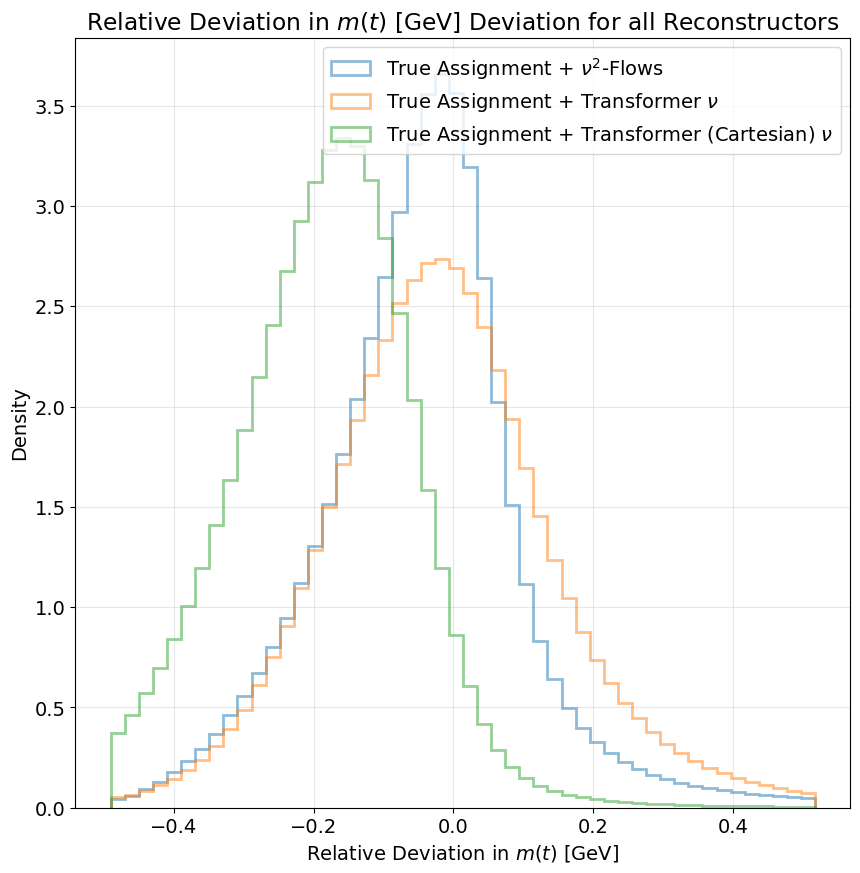

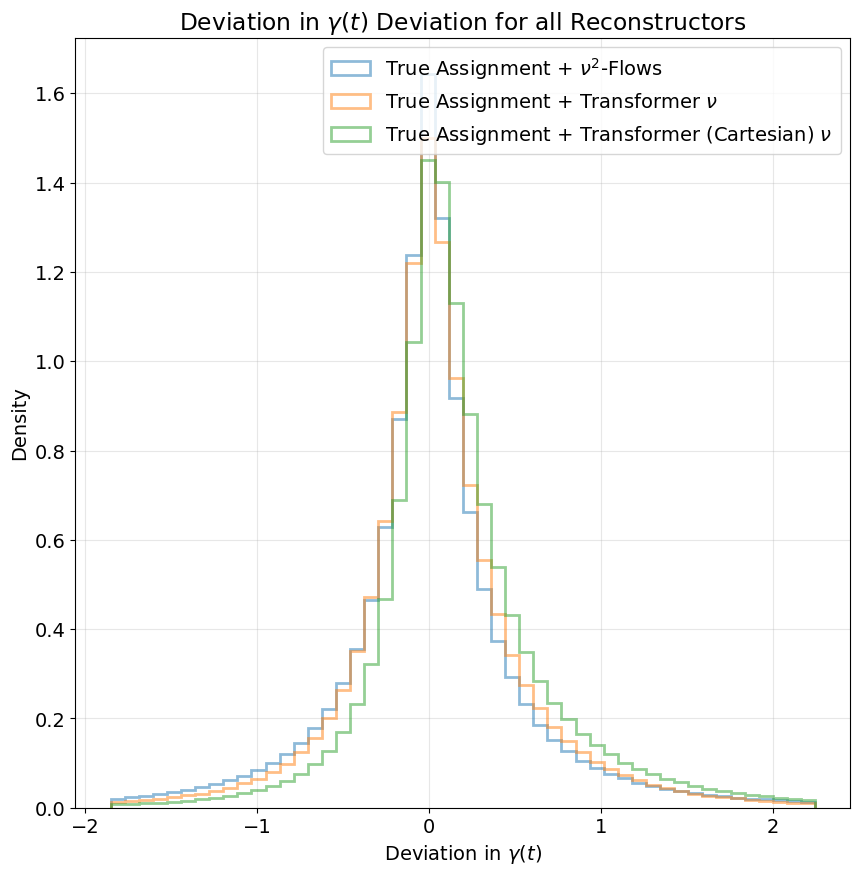

In [9]:
fig, ax = evaluator.plot_variable_deviation("top_px")
fig.savefig(f"{PLOTS_DIR}/top_px_deviation.pdf", bbox_inches="tight")

fig, ax = evaluator.plot_variable_deviation("top_py")
fig.savefig(f"{PLOTS_DIR}/top_py_deviation.pdf", bbox_inches="tight")

fig, ax = evaluator.plot_variable_deviation("top_pz")
fig.savefig(f"{PLOTS_DIR}/top_pz_deviation.pdf", bbox_inches="tight")

fig, ax = evaluator.plot_variable_deviation("top_energy")
fig.savefig(f"{PLOTS_DIR}/top_energy_deviation.pdf", bbox_inches="tight")

fig, ax = evaluator.plot_variable_deviation("top_mass")
fig.savefig(f"{PLOTS_DIR}/top_mass_deviation.pdf", bbox_inches="tight")

fig, ax = evaluator.plot_variable_deviation("top_gamma")
fig.savefig(f"{PLOTS_DIR}/top_gamma_deviation.pdf", bbox_inches="tight")

Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + Transformer $\nu$.
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + Transformer (Cartesian) $\nu$.
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + Transformer $\nu$.
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + Transformer (Cartesian) $\nu$.


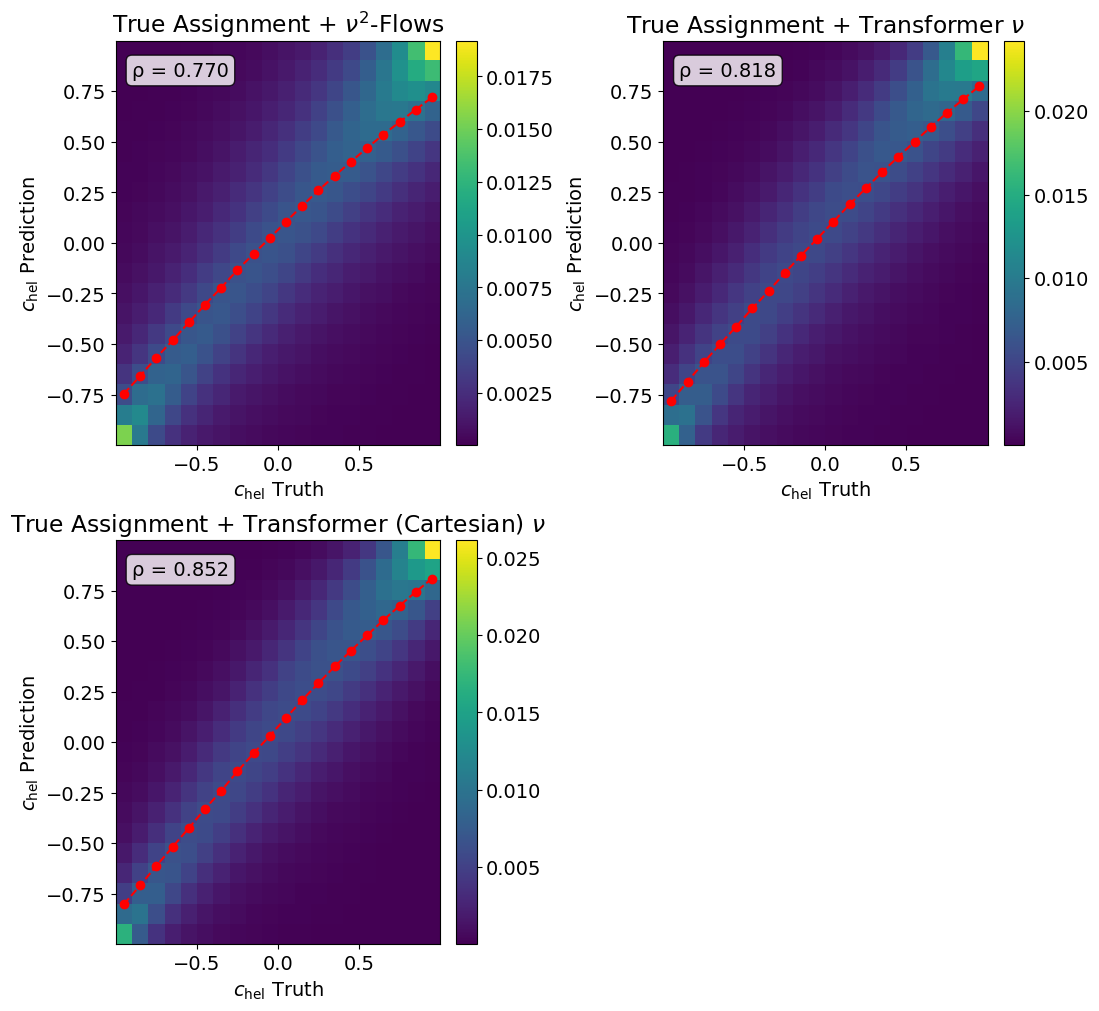

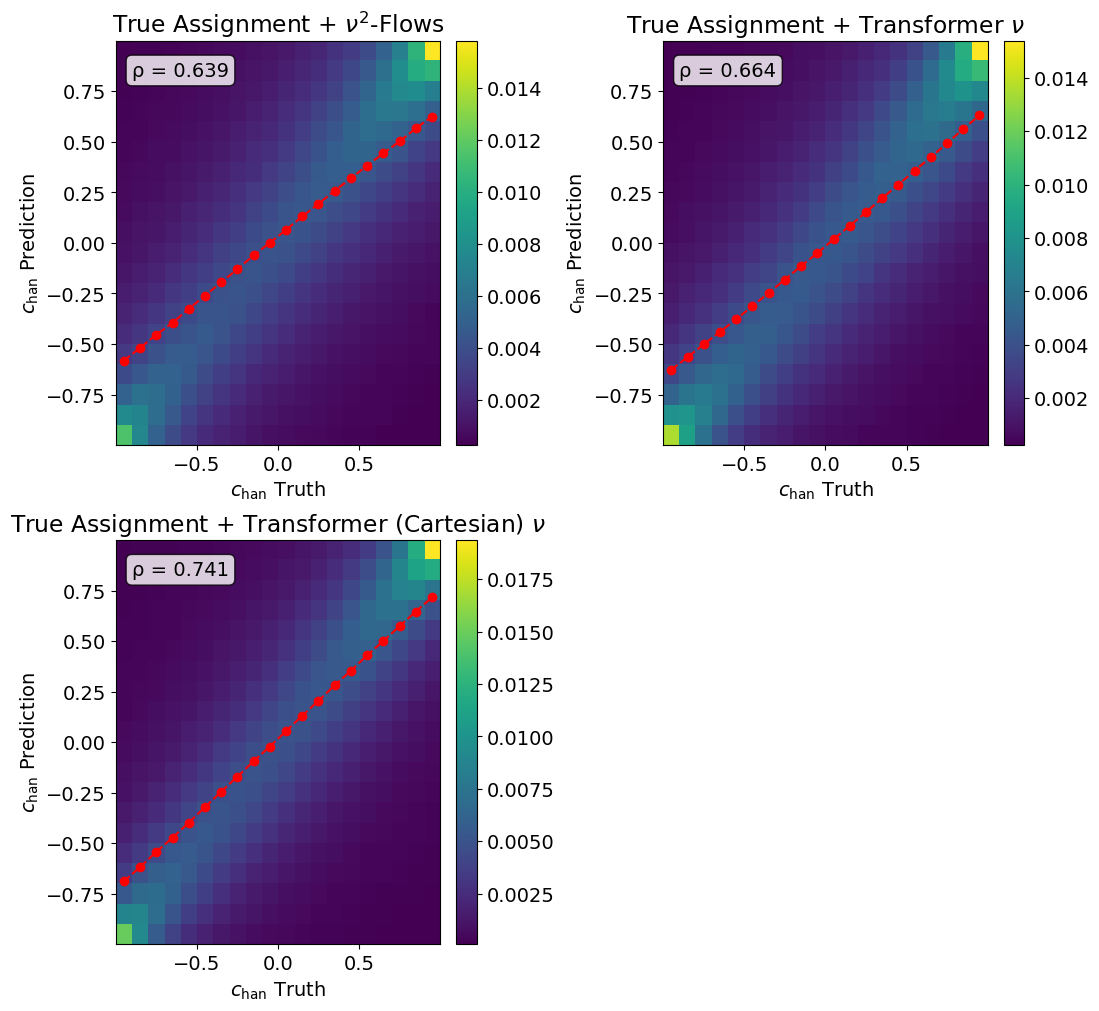

In [10]:
fig, ax = evaluator.plot_variable_confusion_matrix(
    "c_hel", normalize="all", figsize_per_plot=(5.4, 5), bins=20, plot_mean=True
)
fig.savefig(os.path.join(PLOTS_DIR, "c_hel_confusion_matrix.pdf"))

fig, ax = evaluator.plot_variable_confusion_matrix(
    "c_han", normalize="all", figsize_per_plot=(5.4, 5), bins=20, plot_mean=True
)
fig.savefig(os.path.join(PLOTS_DIR, "c_han_confusion_matrix.pdf"))

Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + Transformer $\nu$.
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + Transformer (Cartesian) $\nu$.
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + Transformer $\nu$.
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + Transformer (Cartesian) $\nu$.


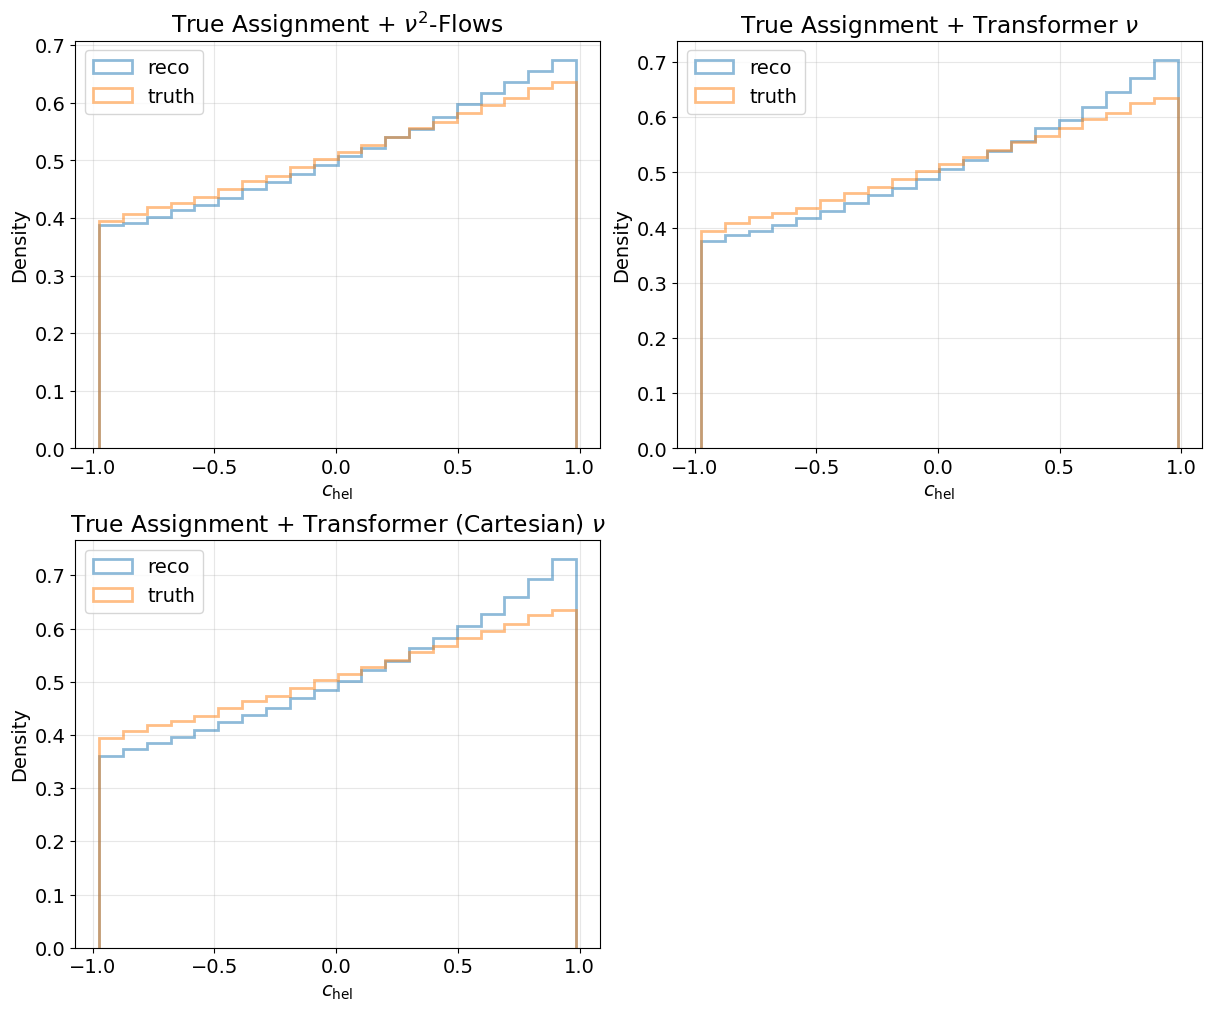

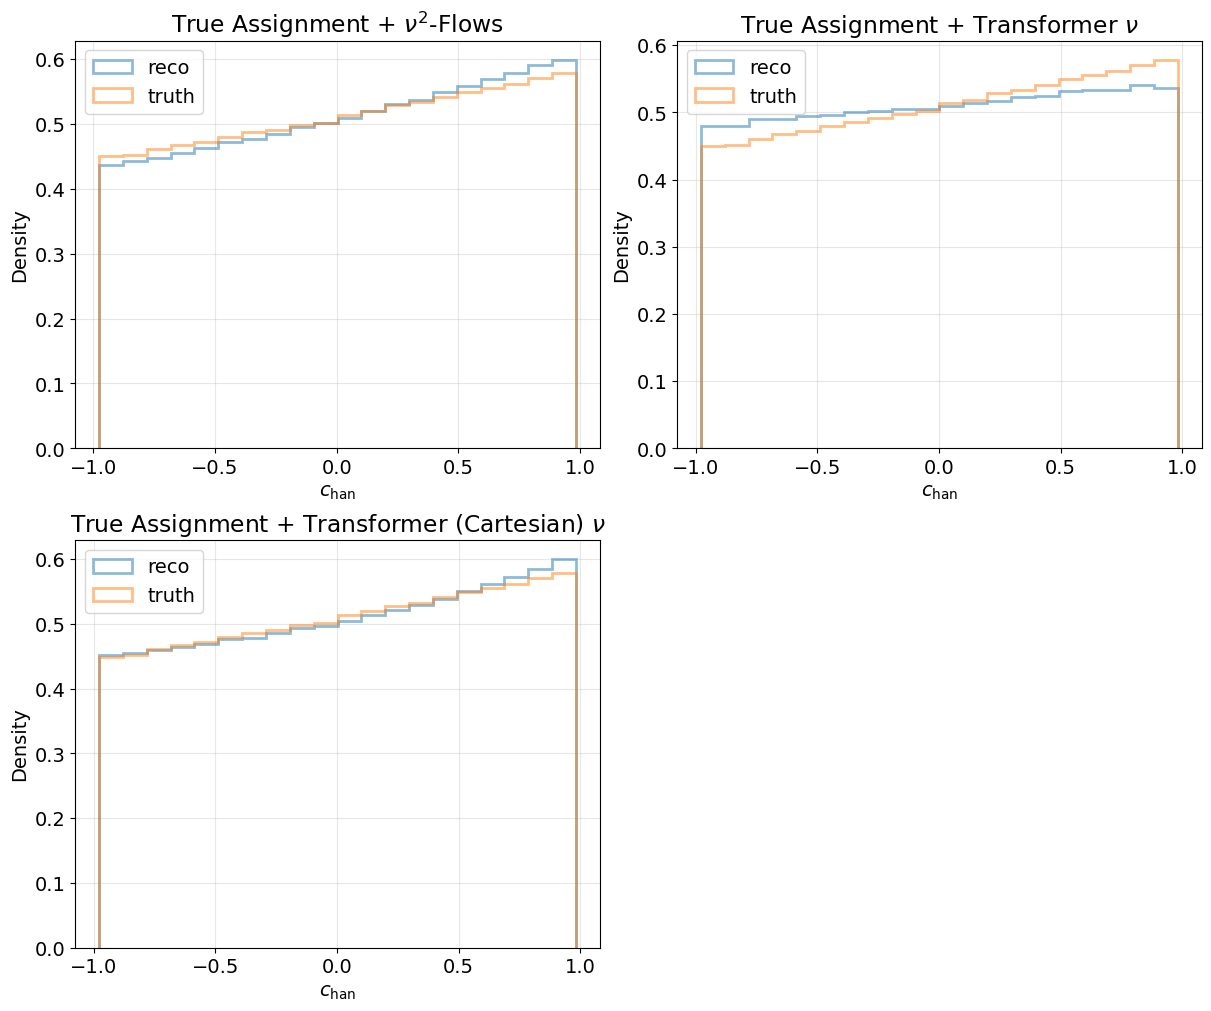

In [11]:
fig, ax = evaluator.plot_variable_distribution("c_hel", bins=20)
fig.savefig(f"{PLOTS_DIR}/c_hel_distribution.pdf", bbox_inches="tight")

fig, ax = evaluator.plot_variable_distribution("c_han", bins=20)
fig.savefig(f"{PLOTS_DIR}/c_han_distribution.pdf", bbox_inches="tight")

Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + Transformer $\nu$.
Using cached reconstructed variable 'c_hel' for reconstructor True Assignment + Transformer (Cartesian) $\nu$.
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + $\nu^2$-Flows.
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + Transformer $\nu$.
Using cached reconstructed variable 'c_han' for reconstructor True Assignment + Transformer (Cartesian) $\nu$.


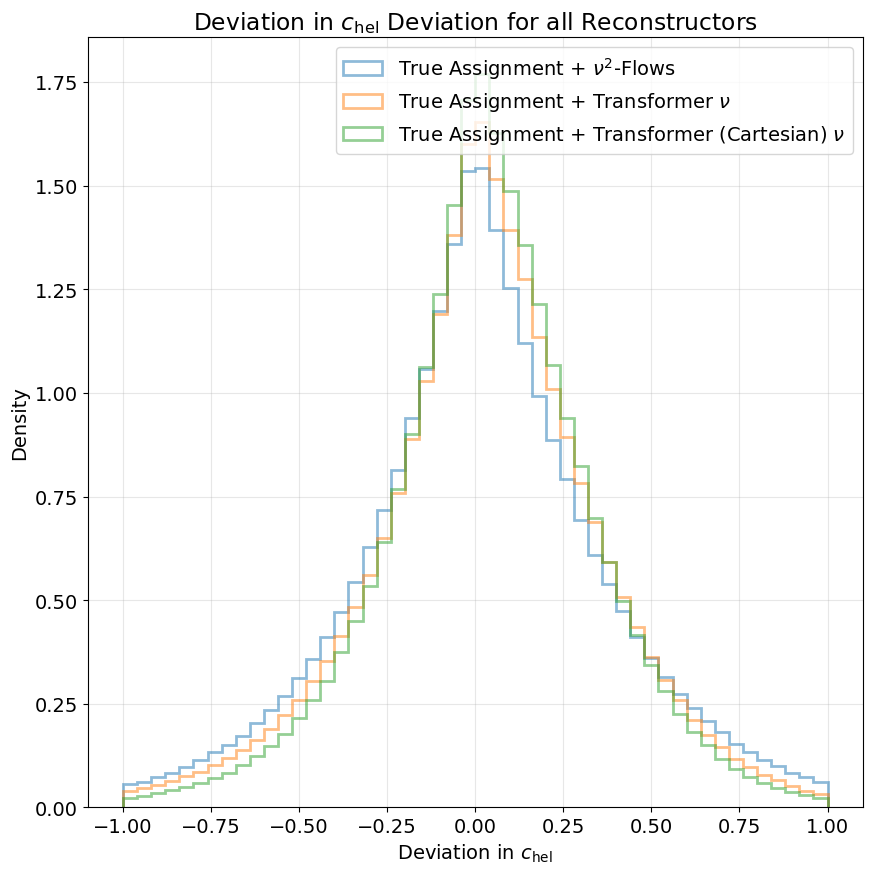

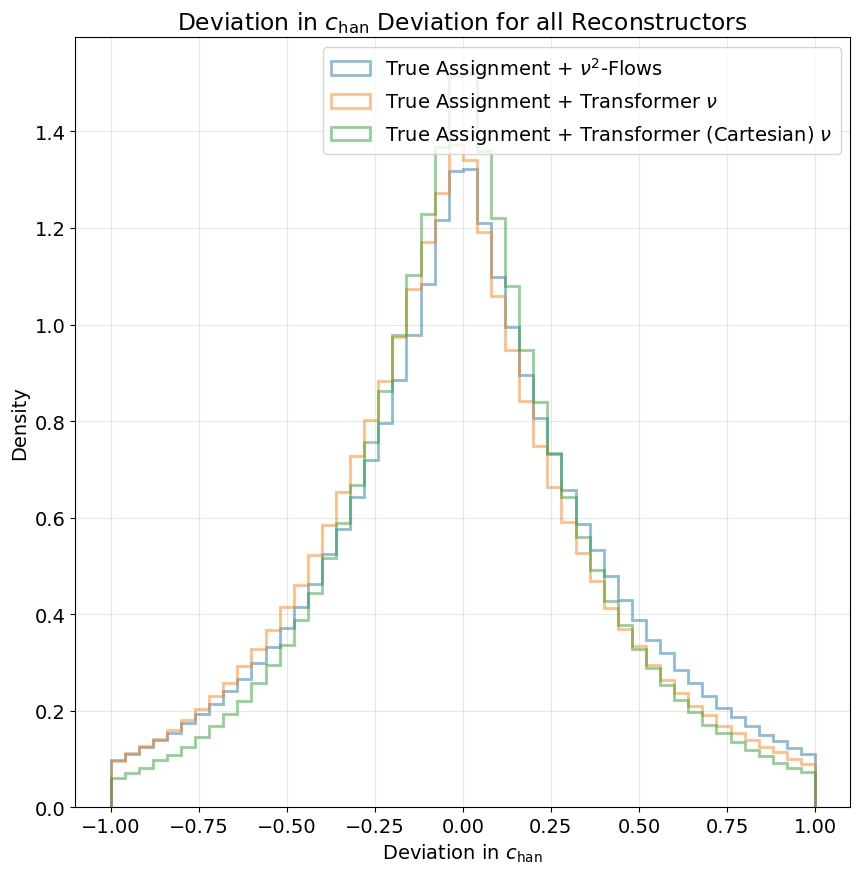

In [12]:
fig, ax = evaluator.plot_variable_deviation("c_hel", xlims=(-1, 1))
fig.savefig(f"{PLOTS_DIR}/c_hel_deviation.pdf", bbox_inches="tight")

fig, ax = evaluator.plot_variable_deviation("c_han", xlims=(-1, 1))
fig.savefig(f"{PLOTS_DIR}/c_han_deviation.pdf", bbox_inches="tight")